# 資料處理

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score
import kagglehub

# general setting. do not change TEST_SIZE
# 這個不能動
RANDOM_SEED = 42
TEST_SIZE = 0.3

################################ 資料處理 ####################################

# load dataset（from kagglehub）
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(f"{path}/creditcard.csv")
# 0 for nonfraud 1 for fraud
data["Class"] = data["Class"].astype(int)

# prepare data
data = data.drop(["Time"], axis=1)  # 去除 time
data["Amount"] = StandardScaler().fit_transform(
    data["Amount"].values.reshape(-1, 1)
)  # 標準化

# 計算詐騙和正常交易的數量 (資料集極度不平衡)
fraud = data[data["Class"] == 1]
nonfraud = data[data["Class"] == 0]
print(f"Fraudulent:{len(fraud)}, non-fraudulent:{len(nonfraud)}")
print(
    f"the positive class (frauds) percentage: {len(fraud)}/{len(fraud) + len(nonfraud)} ({len(fraud)/(len(fraud) + len(nonfraud))*100:.3f}%)"
)

# 選擇非class的值轉成numpy array 且如果原本就是np array時不複製
X = np.asarray(data.iloc[:, ~data.columns.isin(["Class"])])
# 最佳化為 Pandas → NumPy 的不複製轉換
Y = data["Class"].to_numpy()

# split training set and data set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

d:\SCHOOL\機器學習\NTCU-Machine-Learning\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fraudulent:492, non-fraudulent:284315
the positive class (frauds) percentage: 492/284807 (0.173%)


# Ex1 - 監督式學習

## 筆記

關於XGBoost參數:
* eta(0.3) // learning rate(典型值0.01~0.2)
* min_child_weight(1) // 最小樣本權重和，值調大可避免overfitting，太大會underfitting
* max_depth(6) // 樹的最大深度，避免overfitting(典型值3~10)
* gamma(0) // 指定節點分裂所需的最小loss function下降值，值越大算法越保守
* subsample(1) //隨機采樣的比例，越小越不會overfitting(典型值0.5~1)
* scale_pos_weight(1) //處理樣本比例不平衡問題

In [ ]:
########################## train model ################################

xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=8,
    # 處理資料集不平衡
    scale_pos_weight=len(nonfraud) * 2 / len(fraud),
    eval_metric="logloss",
    random_state=RANDOM_SEED,  # 42
)

xgb_model.fit(
    X_train,
    y_train,
)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

# 嘗試不同 threshold
for threshold in [0.5, 0.55, 0.6, 0.65, 0.7]:
    y_pred_thresh = (y_proba > threshold).astype(int)
    print(classification_report(y_test, y_pred_thresh))

y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print("Train F1:", f1_train)
print("Test  F1:", f1_test)

# Ex1 - 非監督式學習

## PCA

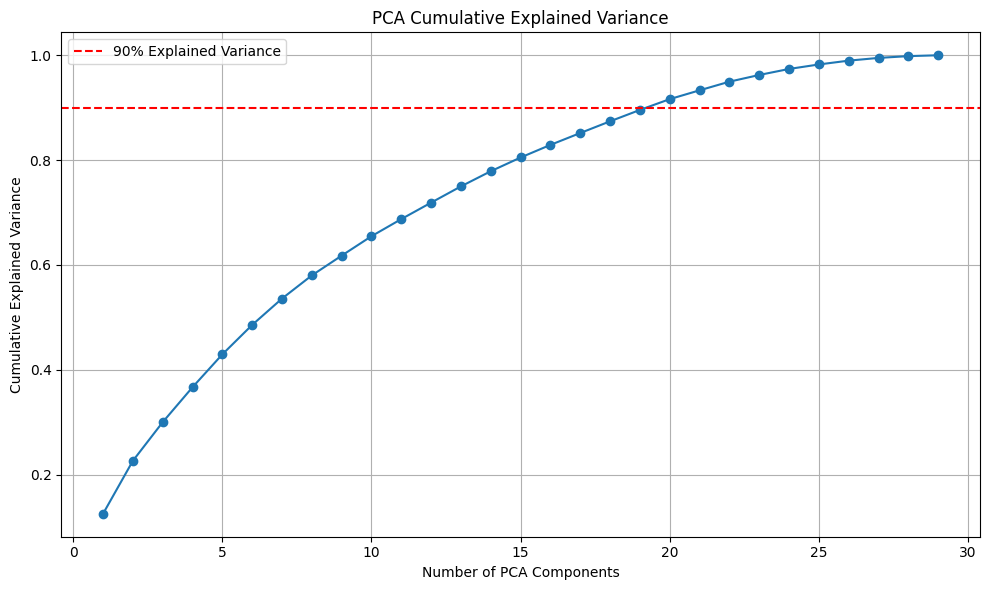

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 假設你的 X_train 是標準化過的資料
pca = PCA().fit(X_train)  # 不指定 n_components，會抓全部維度
explained_ratios = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_ratios) + 1), explained_ratios, marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()


## train & test(Isolation Forest)

In [5]:
pca = PCA(n_components=17, random_state=RANDOM_SEED)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

########################## train model ################################


def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name} Evaluation:")
    print("===" * 15)
    print("         Accuracy:", accuracy)
    print("  Precision Score:", precision)
    print("     Recall Score:", recall)
    print("         F1 Score:", f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


for c in [0.0013,0.0014, 0.0015, 0.0016, 0.0017, 0.0018, 0.0019]:
    iso_model = IsolationForest(
        n_estimators=62,
        contamination=c,
        max_samples=1.0,
        random_state=RANDOM_SEED,
        verbose=0,
    )
    iso_model.fit(X_train_pca)
    preds = (iso_model.predict(X_test_pca) == -1).astype(int)
    evaluation(y_test, preds, model_name=f"IsolationForest (contamination={c:.4f})")



IsolationForest (contamination=0.0013) Evaluation:
         Accuracy: 0.9984082955888721
  Precision Score: 0.5
     Recall Score: 0.375
         F1 Score: 0.42857142857142855

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.50      0.38      0.43       136

    accuracy                           1.00     85443
   macro avg       0.75      0.69      0.71     85443
weighted avg       1.00      1.00      1.00     85443


IsolationForest (contamination=0.0014) Evaluation:
         Accuracy: 0.9983965918799668
  Precision Score: 0.4954128440366973
     Recall Score: 0.39705882352941174
         F1 Score: 0.44081632653061226

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.50      0.40      0.44       136

    accuracy                           1.00     85443
   macro avg       0.75 

## AutoEncoder

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, f1_score
import numpy as np
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 只拿正常樣本訓練
X_train_auto = X_train[y_train == 0]

# 建立 AutoEncoder 結構
input_dim = X_train.shape[1]
encoding_dim = 17  # 壓縮
hidden_dim = int(encoding_dim / 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(
    encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(1e-5)
)(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="tanh")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")


def evaluation(y_true, y_pred, model_name="Model"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name} Evaluation:")
    print("===" * 15)
    print("         Accuracy:", accuracy)
    print("  Precision Score:", precision)
    print("     Recall Score:", recall)
    print("         F1 Score:", f1)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


# 訓練
autoencoder.fit(
    X_train_auto,
    X_train_auto,
    epochs=40,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    verbose=1,
)

X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

for c in [99.7, 99.75, 99.8, 99.85, 99.9]:
    threshold = np.percentile(mse, c) 
    y_pred = (mse > threshold).astype(int)
    
    evaluation(y_test, y_pred, model_name="AutoEncoder")

Epoch 1/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.7138 - val_loss: 0.4539
Epoch 2/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4379 - val_loss: 0.3857
Epoch 3/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3771 - val_loss: 0.3514
Epoch 4/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3490 - val_loss: 0.3373
Epoch 5/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3362 - val_loss: 0.3278
Epoch 6/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3271 - val_loss: 0.3225
Epoch 7/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3200 - val_loss: 0.3161
Epoch 8/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3145 - val_loss: 0.3108
Epoch 9/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3087 - val_loss: 0.3058
Epoch 10/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3026 - val_loss: 0.3002
Epoch 11/40
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2976 - val_loss: 0.2949
Epoch 12/40
2799/2799 ━━━━━━━━